# Project Regression: Capital Bike Share 

#### Build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set, in order to predict demand for bicycle rentals at any given hour, based on time- and weather-related features.

This project follows a Machine Learning process similar to the one you learned last week.

Key steps:

* exploratory data analysis
* train/test split
* feature engineering
* train a model
* cross-validation
* optimize the model iteratively, select features, try different regressors (e.g. Linear Regression, Random Forest Regressor, SVR)
* calculate a test score when you are done
* submit to Kaggle

Data Fields

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

Import libraries

In [48]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

Import datasets

In [7]:
df = pd.read_csv('/Users/braulio/Documents/data/train.csv', index_col=0)

# 1. exploratory data analysis

In [9]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
df.shape

(10886, 11)

In [11]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6+ KB


### no missing values!

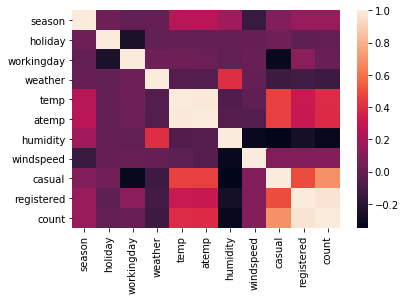

In [13]:
# Correlation heatmap:

sns.heatmap(df.corr())

Which factors seem to have the strongest correlation with Count?:
* Registered users seems to indicate a 1v1 correlation with count
* Registered and Casual correlate with each other, and count
* Temp and atemp have strong correlation with count

other takes:
* Weather correlates with humidity

### Create time-related features
Create new df with segragated timestamps

* 1. Set index as column

* 2. Separate out hour and day in new columns

In [15]:
df.reset_index(inplace = True) #set index as column

In [16]:
# separate date/time features from datetime

# convert datetime column into datetime type:
df['hour'] = pd.to_datetime(df['datetime']).dt.hour

df['day of the week'] = pd.to_datetime(df['datetime']).dt.day_name()

df['day'] = pd.to_datetime(df['datetime']).dt.day

df['month'] = pd.to_datetime(df['datetime']).dt.month

df['year'] = pd.to_datetime(df['datetime']).dt.year

# set datetime as index again
df.set_index('datetime', inplace = True)

In [19]:
df.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day of the week,day,month,year
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,Saturday,1,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,Saturday,1,1,2011


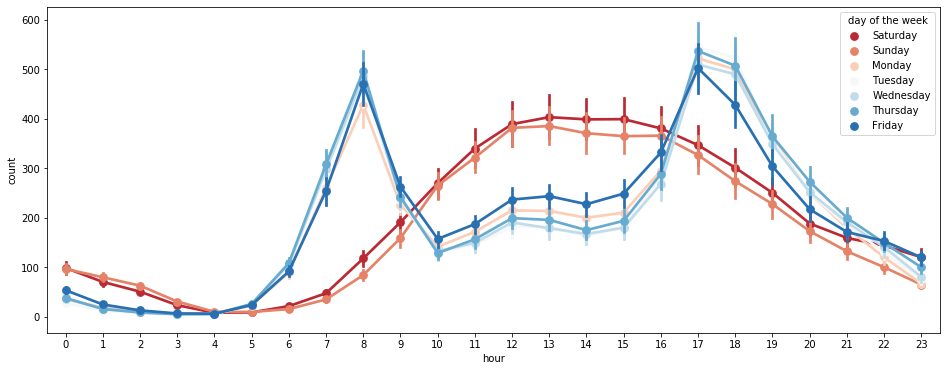

In [20]:
plt.figure(figsize=(16,6))

sns.pointplot(x = "hour", y = "count", data = df, hue = "day of the week", palette = "RdBu", legend='full')

As this graph points out, the weekend -- Saturday and Sunday -- has clearly a different trend throughout the day when compared to weekdays. In fact, at the time we want to predict, Saturday at 14h, there is a peak in checked-out bikes. 12h to 15h seems to be the peak hours of bike rentals during the weekends. 

.
.
.

also shown through:

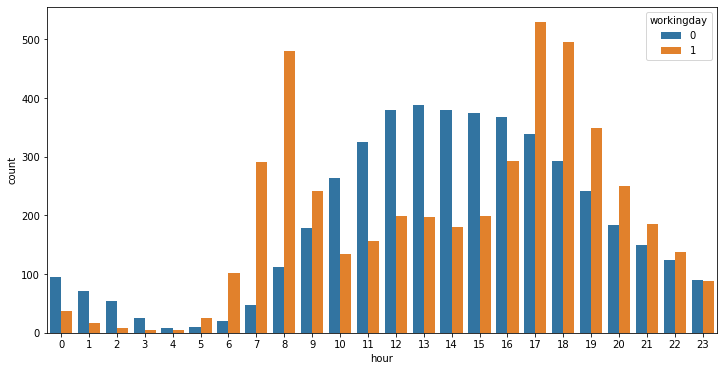

In [22]:
hours = df.groupby(['hour', 'workingday']).mean()
hours.reset_index(inplace = True)

plt.figure(figsize=(12,6))
sns.barplot(x = 'hour', y = 'count', data = hours, hue = 'workingday')

In [23]:
#Correlations with count at hour 14:00

df[df['hour'] == 14].drop(columns=['year','month','day']).corr()[['count']]

,count
season,0.267909
holiday,0.090224
workingday,-0.626703
weather,-0.247362
temp,0.369362
atemp,0.378329
humidity,-0.189433
windspeed,-0.056738
casual,0.936362
registered,0.952045


#### At 14:00, the strongest correlations with bike checkouts:

* Workingday: -62%
* atemp and temp: 38% and 37%
* Season: 26%
* Weather: -24%

In [24]:
#Correlations with count on the weekends

df[df['workingday'] == 0].drop(columns=['year','month','day']).corr()[['count']]

,count
season,0.172435
holiday,-0.004746
workingday,NaN
weather,-0.137250
temp,0.504788
atemp,0.502562
humidity,-0.425693
windspeed,0.110578
casual,0.936856
registered,0.972264


#### On the weekends, the strongest correlations with bike checkouts:

* atemp and temp: 50%
* humidity: -42%
* Hour: 38%
* Weather: -14%

### Registered vs Casual users: a final review

So far, both users have shown strong correlation with each other and counts, therefore not showing much difference in behaviour and signs of being significant enough to be included in the analysis. In fact, as we can see on samples on the table: Registered + Casual = count, thus we can ignore those variables.

New dateframe to test factors that influence rentals only on weekends and at 14h00: df0

In [26]:
df0 = df[df['workingday'] == 0] #only non workingdays
df0 = df0[df0['hour'] == 14] #only at 14h00
df0 = df0.drop(columns=['casual','registered']) #remove registered and casual columns

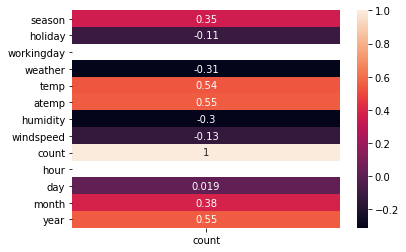

In [27]:
sns.heatmap(df0.corr()[['count']], annot=True)

#### Which factors contribute most to the number of bicycles being checkout out over the course of a given day?

* temp and atemp
* year/ month
* season
* weather and humidty 

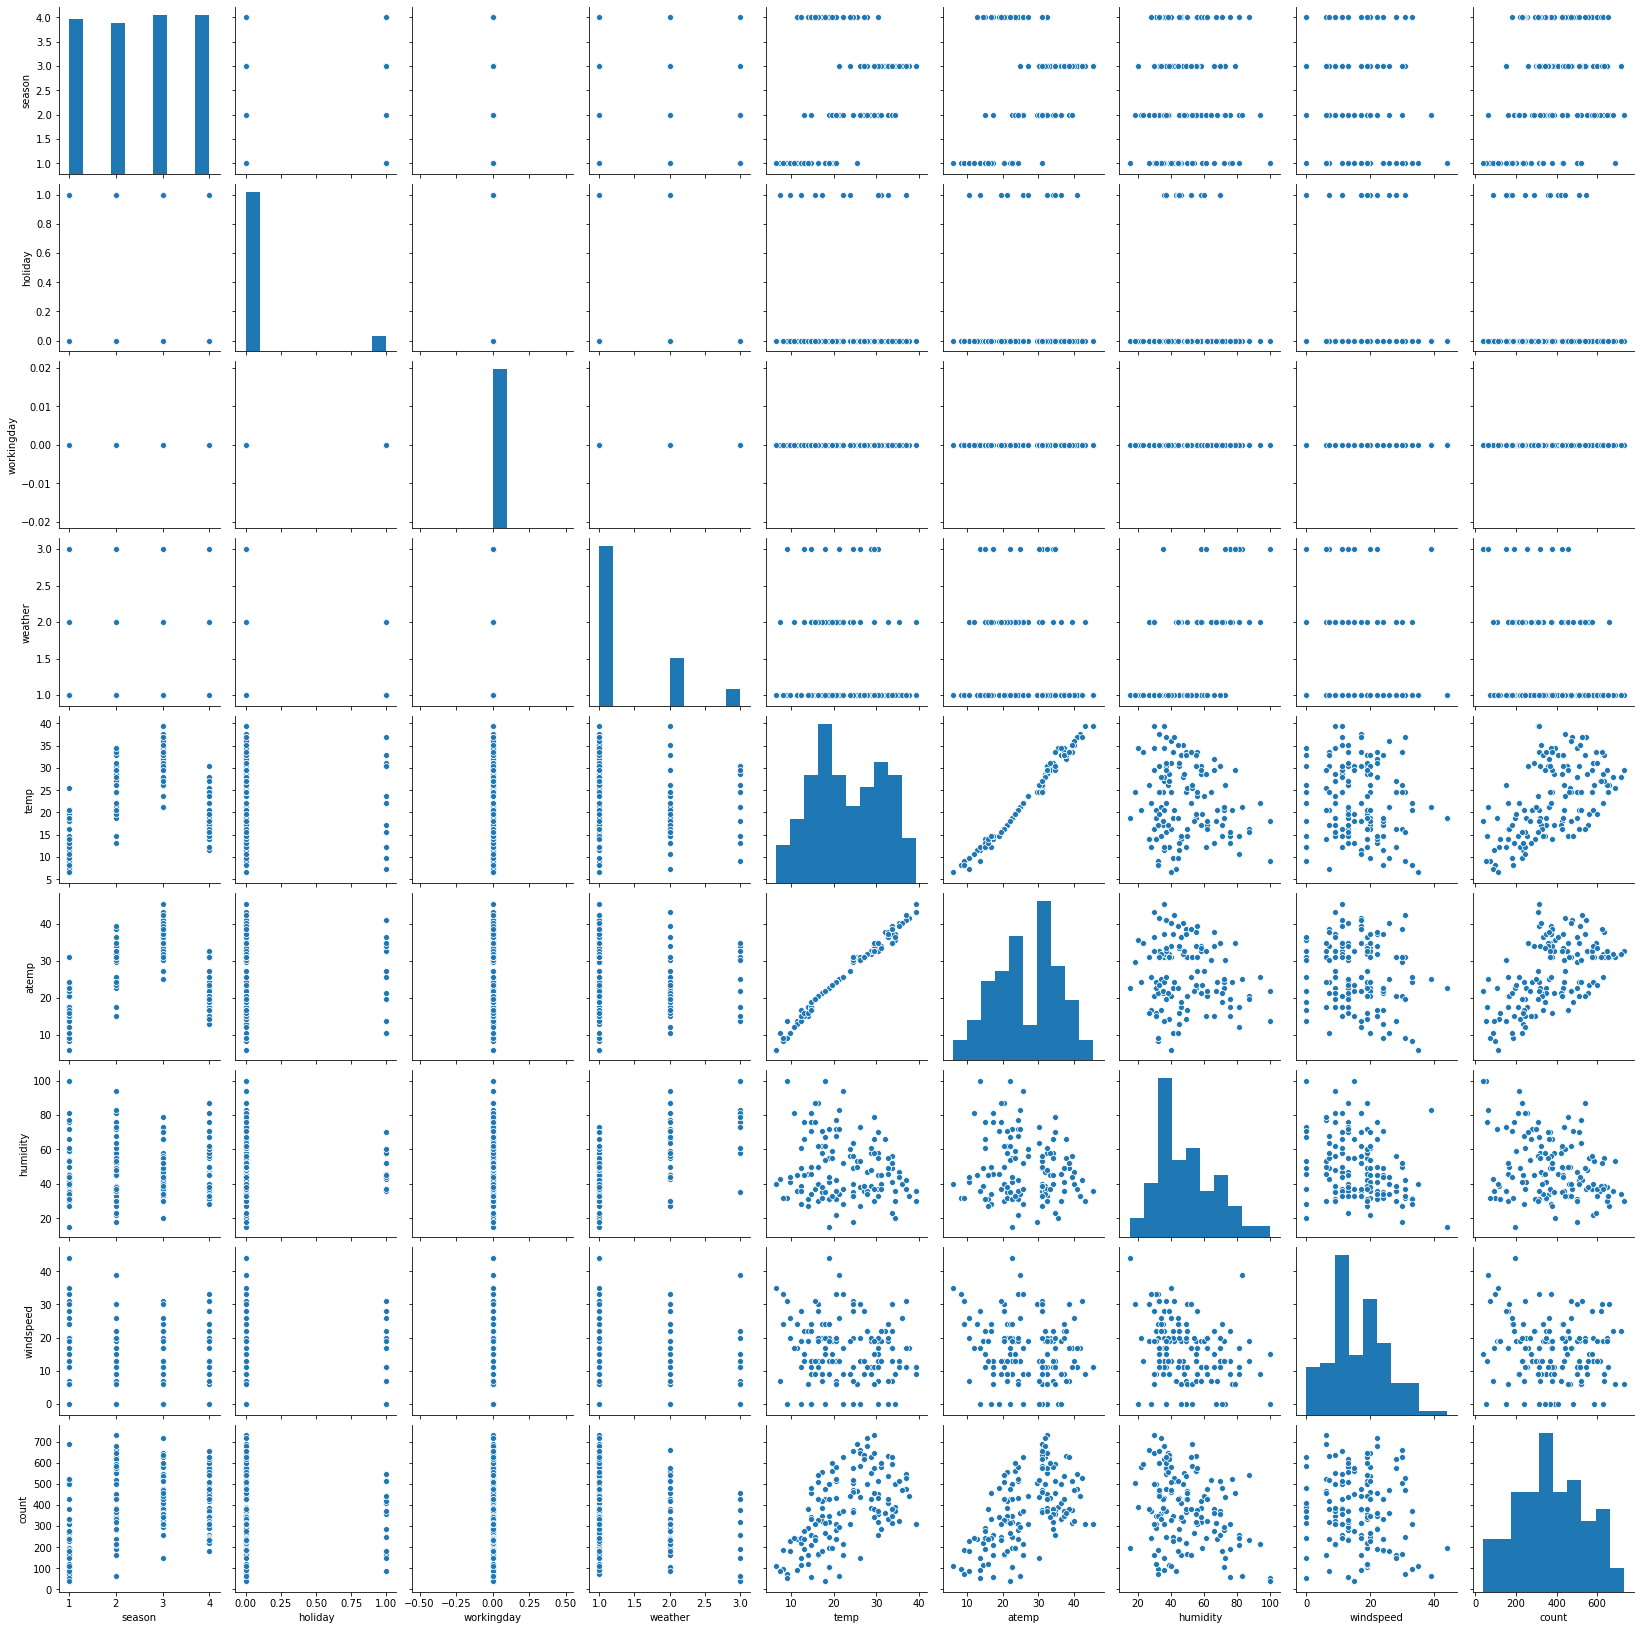

In [29]:
# Plot the relationships
sns.pairplot(df0.drop(columns=['year','month','hour', 'day']))

The only apparent linear relationship on the graphs, relating with Count, is temp and atemp


### Analyze weather and season

In [31]:
df.groupby('weather').count()

,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,hour,day of the week,day,month,year
weather,,,,,,,,,,,,,,,
1,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192
2,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834
3,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


#### Only once Weather 4 is shown in the dataset, thus an analysis on its pattern is not possible

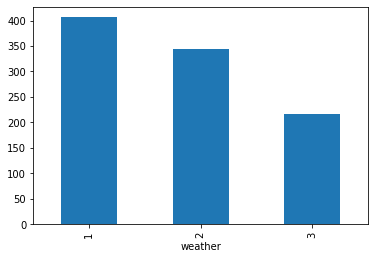

In [32]:
df0.groupby('weather').mean()['count'].plot.bar()

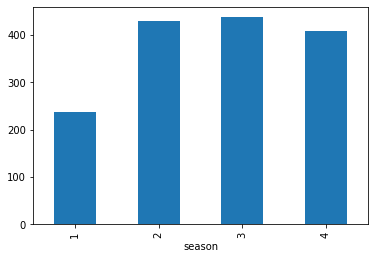

In [33]:
df0.groupby('season').mean()['count'].plot.bar()

In [34]:
df.corr()[['season']]

,season
season,1.000000
holiday,0.029368
workingday,-0.008126
weather,0.008879
temp,0.258689
atemp,0.264744
humidity,0.190610
windspeed,-0.147121
casual,0.096758
registered,0.164011


#### Season is highly correlated with month, almost 100%, therefore we can use one of them as a feature

## Final considerations

### Important features that impact the number of bicycles being checkout, 
most specifically on Saturdays at 14h:
* temp and atemp
* Season
* Weather and Humidty

# 2. train/test split

In [35]:
X = df.drop(['count'], axis=1)

In [42]:
df.reset_index(inplace = True)

y = df[['datetime', 'count']].set_index('datetime')

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [50]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8164, 15), (2722, 15), (8164, 1), (2722, 1))

# 3. feature engineering

In [63]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day of the week,day
datetime,,,,,,,,,,,
2012-08-11 13:00:00,3,0,0,1,32.80,37.120,49,23.9994,13,Saturday,11
2012-12-13 13:00:00,4,0,1,1,14.76,17.425,34,12.9980,13,Thursday,13
2012-09-07 17:00:00,3,0,1,1,31.98,37.120,59,22.0028,17,Friday,7
2011-11-09 20:00:00,4,0,1,1,18.04,21.970,77,0.0000,20,Wednesday,9
2012-12-16 04:00:00,4,0,0,2,13.94,18.180,87,0.0000,4,Sunday,16


Start by dropping unwanted columns

In [62]:
X_train = X_train.drop(['casual', 'registered', 'year', 'month'], axis = 1)

KeyError: "['casual' 'registered' 'year' 'month'] not found in axis"

In [64]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day of the week,day
datetime,,,,,,,,,,,
2012-08-11 13:00:00,3,0,0,1,32.80,37.120,49,23.9994,13,Saturday,11
2012-12-13 13:00:00,4,0,1,1,14.76,17.425,34,12.9980,13,Thursday,13
2012-09-07 17:00:00,3,0,1,1,31.98,37.120,59,22.0028,17,Friday,7
2011-11-09 20:00:00,4,0,1,1,18.04,21.970,77,0.0000,20,Wednesday,9
2012-12-16 04:00:00,4,0,0,2,13.94,18.180,87,0.0000,4,Sunday,16
